<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>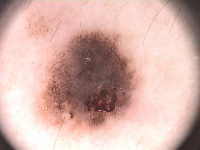</td><td>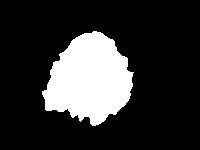</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!pip uninstall -y opencv-python-headless
!pip install -Iv opencv-python-headless==4.1.2.30

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 6.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2022-05-09 05:37:45--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2022-05-09 05:37:45--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ef1715e53cd5e517d2f09ef67.dl.dropboxusercontent.com/cd/0/inline/Bk4vw0_DjxcTHdg820F6G3xIsiW2pGaVvCs2ZaY7pzVcSqf8qDf1llJVytvRLgniS0TojkCkFdtoTDHb5oxpT2KxA65SRRABNjxquld2MOmyQ9HgOPm4hjoxVPHIfBHk8eO1dXlShWGtdy2AJqM7ow1NAJv3AFtRX5GXU1bSswRwVw/file# [following]
--2022-05-09 05:37:45--  https://uc3ef1715e53cd5e517d2f09ef67.dl.dropboxusercontent.com/cd/0/inline/Bk4vw0_DjxcTHdg820F6G3xIsiW2pGaVvCs2ZaY7pzVcSqf8qDf1llJVytvRLg

In [2]:
# !pip install googledrivedownloader

In [3]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
#                                     dest_path='./PH2Dataset.rar',
#                                     unzip=False)

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torchsummary import summary
from time import time
from tqdm import tqdm
from matplotlib import rcParams
import albumentations as A
# from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns 
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import math
import numpy as np
rcParams['figure.figsize'] = (17,12)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Зафиксируем случайности

In [2]:
seed = 55
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnnbenchmark = True
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

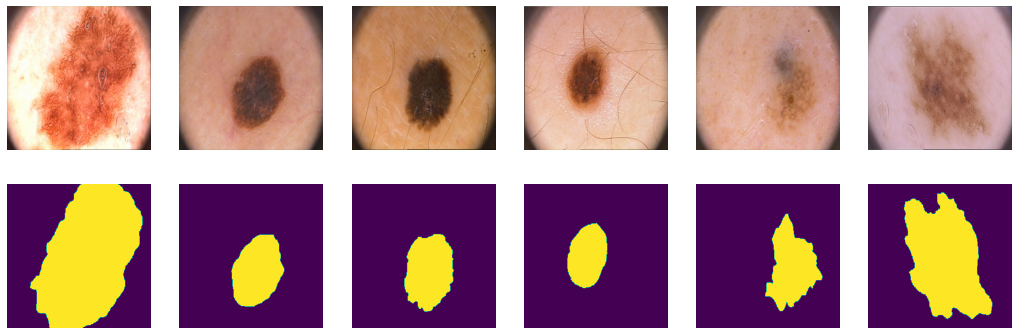

In [7]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
len(X[tr])

100

In [11]:
class PH2Dataset(Dataset):
    def __init__(self, X_data, Y_data, transforms=None):
        self.X_data = X_data
        self.Y_data = Y_data
        self.transforms = transforms
        assert len(X_data) == len(Y_data)

        self.len_ = len(self.X_data)

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        if self.transforms is not None:

            transform = self.transforms

            x_item = self.X_data[index]
            y_item = self.Y_data[index]

            transformed = transform(image=x_item, mask=y_item)
        
            x = np.rollaxis(transformed["image"], 2, 0)
            y = transformed["mask"][np.newaxis, :, :]
            
            return x, y
        
        else:
            x_item = self.X_data[index]
            y_item = self.Y_data[index]

            x = np.rollaxis(x_item, 2, 0)
            y = y_item[np.newaxis, :, :]
            return x, y


In [12]:
transform = A.Compose([
                       A.RandomCrop(width=256, height=256),
                       A.HorizontalFlip(p=0.5),
                       A.Rotate(limit=90),
                       A.RandomBrightnessContrast(p=0.2)
            ])

In [13]:
batch_size = 10
train_data = PH2Dataset(X[tr], Y[tr], transforms=transform)
val_data = PH2Dataset(X[val], Y[val])
test_data = PH2Dataset(X[ts], Y[ts])

data_tr = DataLoader(train_data, 
                     batch_size=batch_size, 
                     shuffle=True, num_workers=2)
data_val = DataLoader(val_data,
                      batch_size=batch_size, 
                      shuffle=False, num_workers=0)
data_ts = DataLoader(test_data,
                     batch_size=batch_size, 
                     shuffle=False, num_workers=0)



# data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
#                      batch_size=batch_size, shuffle=True)
# data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
#                       batch_size=batch_size, shuffle=True)
# data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
#                      batch_size=batch_size, shuffle=False)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

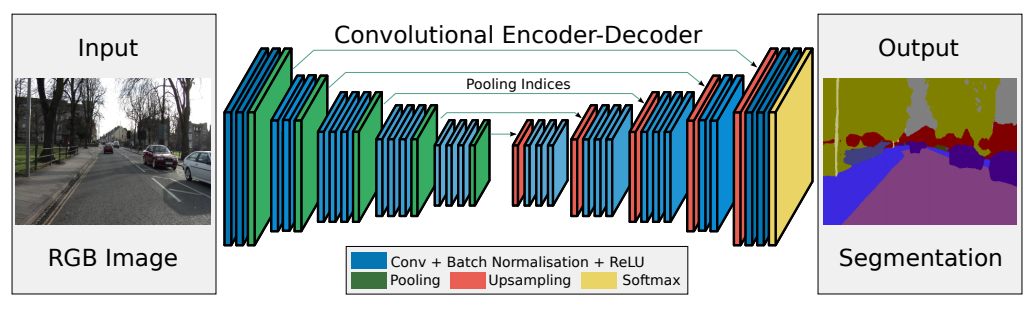

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [17]:
from skimage.util import pad
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
            )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=(3,3), stride=(1,1), 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
            )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
            )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 32 -> 16

        # повторяем полную архитектуру на картинке, поэтому добавляем и 5ю часть в энкодере
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
            )
        
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)# 8 -> 16

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
            )
        
        self.upsample1 =  nn.MaxUnpool2d(kernel_size=2, stride=2)# 16 -> 32

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 64 -> 128

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
            )
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256

        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, 
                      kernel_size=1, stride=1)
            )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        e4, ind4 = self.pool4(self.enc_conv4(e3))

        # residual bottleneck
        b = self.bottleneck_conv(e4) + e4

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind4))
        d1 = self.dec_conv1(self.upsample1(d0, ind3))
        d2 = self.dec_conv2(self.upsample2(d1, ind2))
        d3 = self.dec_conv3(self.upsample3(d2, ind1))
        d4 = self.dec_conv4(self.upsample4(d3, ind0))  # no activation
        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [19]:
def bce_loss(y_pred, y_real, reduction=None):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_pred * y_real + 
                    torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [20]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    #collect avg loss on batch to plot it
    loss_array = []
    val_loss_array = []
    epoch_time = []
    for epoch in tqdm(range(epochs)):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch) 

            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        time_one_epoch = toc - tic
        epoch_time.append(time_one_epoch)
        # print(f'loss: {avg_loss}, time: {time_one_epoch}' )
        loss_array.append(avg_loss.detach().cpu().numpy())
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu
        
        val_loss_array.append(loss_fn(Y_hat, Y_val))

        scheduler.step()
        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(torch.sigmoid(Y_hat[k, 0]), cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(4, 6, k+13)
            plt.imshow((torch.sigmoid(Y_hat[k, 0]) > 0.5).type(torch.float), cmap='gray')
            plt.title('Prediction')
            plt.axis('off')

            # построить размеченные данные для наглядности
            plt.subplot(4, 6, k+19)
            plt.imshow(Y_val[k].numpy().reshape(256, 256))
            plt.title('Lesion')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        plt.figure(figsize=(18, 6))
        plt.plot(loss_array, label="train_loss")
        plt.plot(val_loss_array, label="val_loss")
        plt.legend()
        plt.grid()
        plt.show()

        del Y_pred, X_batch, Y_batch, Y_hat
        torch.cuda.memory.empty_cache()


## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [21]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred_list = []
    Y_label_list = []
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device).detach()
            Y_pred = torch.sigmoid(model(X_batch).cpu())
            Y_pred_list.append(Y_pred)
            Y_label_list.append(Y_label)

            del X_batch, Y_pred
            torch.cuda.empty_cache()

        Y_pred = (torch.cat(Y_pred_list, dim=0) > 0.5).type(torch.float)
        Y_label = torch.cat(Y_label_list, dim=0)    
    return Y_pred, Y_label#np.array(Y_pred)

In [22]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    Y_pred, Y_label = predict(model, data)
    scores = metric(Y_pred, Y_label).mean().item()

    return scores

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [74]:
model = SegNet().to(device)

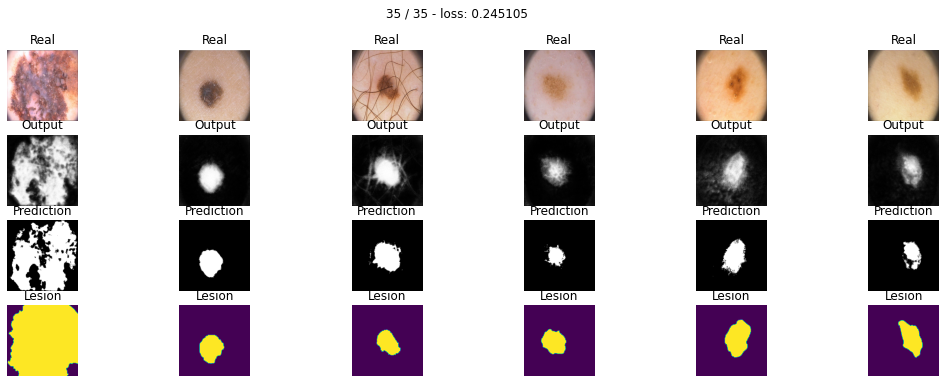

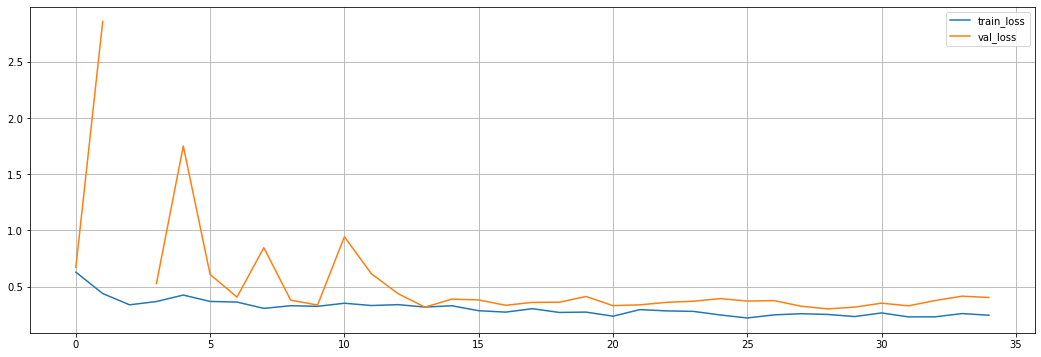

100%|██████████| 35/35 [05:48<00:00,  9.97s/it]


In [24]:
max_epochs = 35
opt = torch.optim.AdamW(model.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=15, gamma=0.5)
train(model, opt, exp_lr_scheduler, bce_loss, max_epochs, data_tr, data_val)

In [25]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.5600000023841858

In [26]:
score_model(model, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.624000072479248

In [75]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [76]:
del model

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [28]:
def dice_loss(y_pred, y_real):
    SMOOTH = 1e-3
    num = (2. * torch.sigmoid(y_pred) * y_real).sum()
    den =  (torch.sigmoid(y_pred) + y_real).sum()
    res = 1 - (num+SMOOTH) / (den+SMOOTH)
    return res

Проводим тестирование:

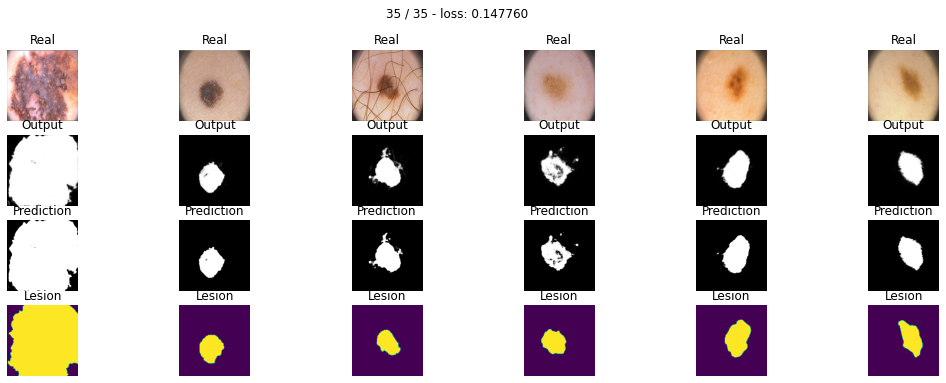

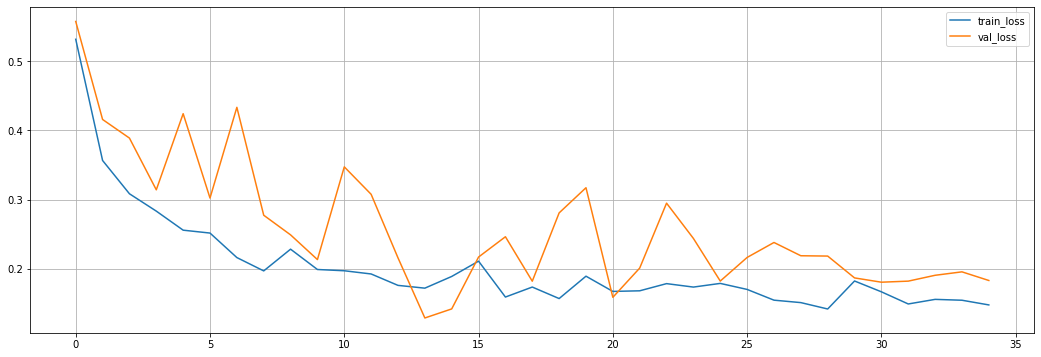

100%|██████████| 35/35 [05:51<00:00, 10.03s/it]


In [29]:
model_dice = SegNet().to(device)

max_epochs = 35
optimaizer = torch.optim.AdamW(model_dice.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=15, gamma=0.5)
train(model_dice, optimaizer, exp_lr_scheduler, dice_loss, max_epochs, data_tr, data_val)

In [30]:
score_model(model_dice, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6540000438690186

In [31]:
score_model(model_dice, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6840000152587891

In [32]:
del model_dice

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [35]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    p = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)# hint: torch.clamp
    ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")
    p_t = p * y_real + (1 - p) * (1 - y_real)
    foc_loss = ce_loss * ((1 - p_t) ** gamma)
    return torch.mean(foc_loss)

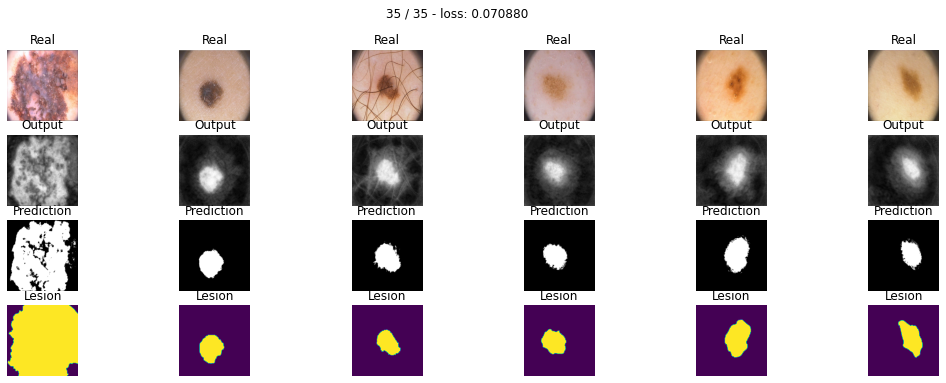

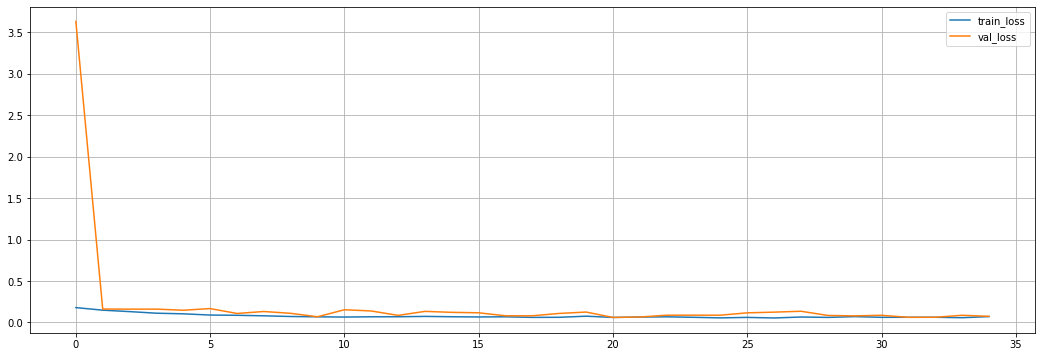

100%|██████████| 35/35 [05:49<00:00,  9.99s/it]


In [36]:
model_focal = SegNet().to(device)

max_epochs = 35
optimaizer = optim.AdamW(model_focal.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=15, gamma=0.5)
train(model_focal, optimaizer, exp_lr_scheduler, focal_loss, max_epochs, data_tr, data_val)

In [37]:
score_model(model_focal, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6559998989105225

In [38]:
score_model(model_focal, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6839999556541443

In [39]:
del model_focal

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

[**3. Log-Cosh Dice Loss:**](https://arxiv.org/abs/2006.14822)

In [40]:
def log_cosh_loss(y_pred, y_real):
    x = dice_loss(y_pred, y_real)

    return torch.log((torch.exp(x) + torch.exp(-x)) / 2.0)

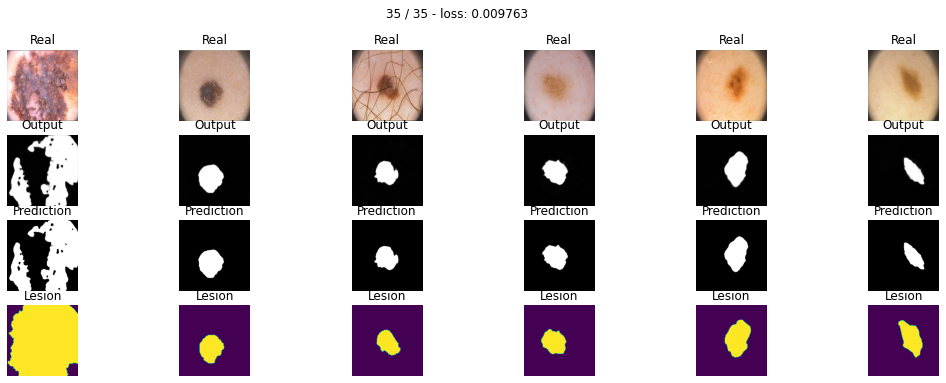

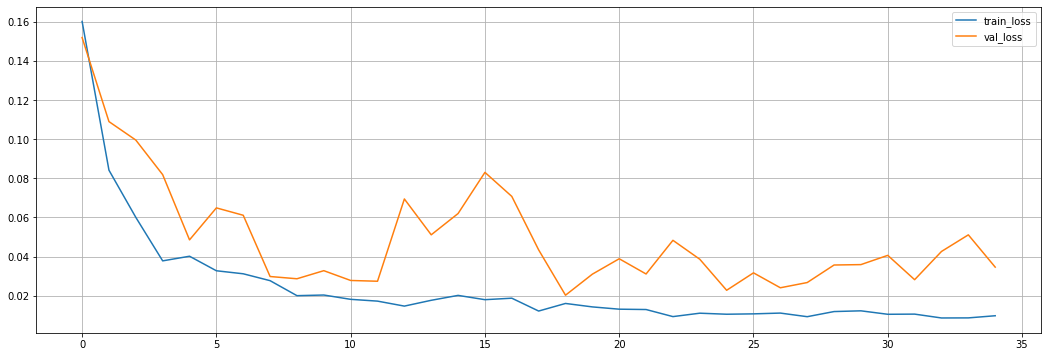

100%|██████████| 35/35 [05:49<00:00,  9.97s/it]


In [41]:
model_log = SegNet().to(device)

max_epochs = 35
optimaizer = optim.AdamW(model_log.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=15, gamma=0.5)
train(model_log, optimaizer,exp_lr_scheduler, log_cosh_loss, max_epochs, data_tr, data_val)

In [42]:
score_model(model_log, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.5980000495910645

In [43]:
score_model(model_log, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6859999895095825

In [44]:
del model_log

[**4. Distance map derived loss penalty term:**](https://arxiv.org/abs/2006.14822)

In [47]:
def distance_loss(y_pred, y_real):
    return ((1 + torch.cdist(torch.sigmoid(y_pred), y_real)) * 
            F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")).mean()

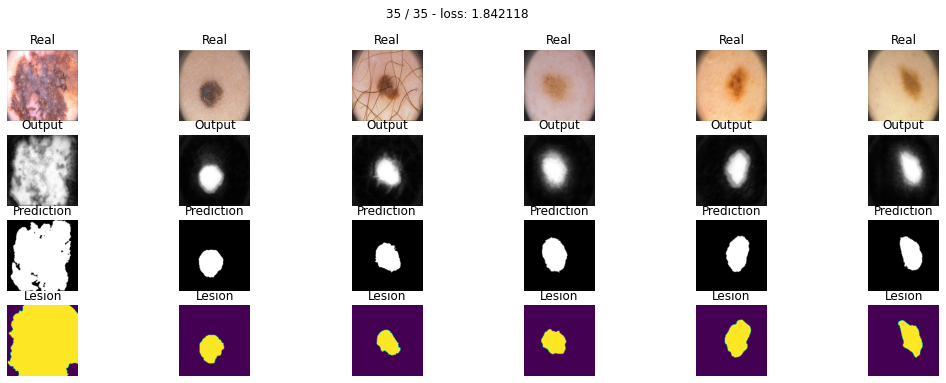

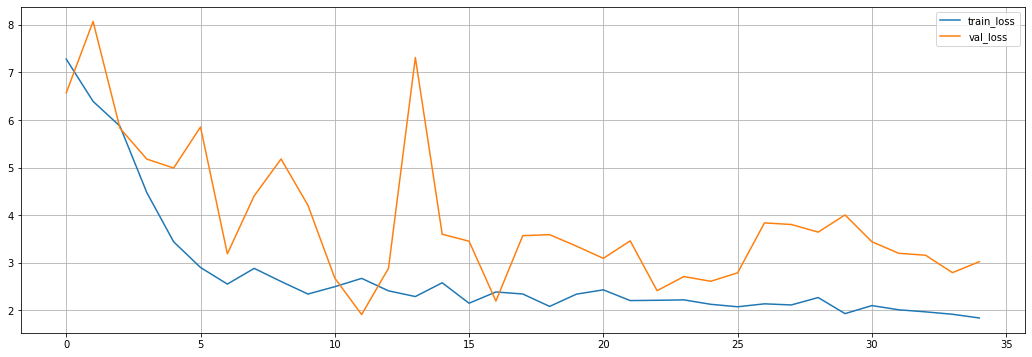

100%|██████████| 35/35 [05:48<00:00,  9.95s/it]


In [48]:
model_dist = SegNet().to(device)

max_epochs = 35
optimaizer = optim.AdamW(model_dist.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=15, gamma=0.5)
train(model_dist, optimaizer, exp_lr_scheduler, distance_loss, max_epochs, data_tr, data_val)

In [49]:
score_model(model_dist, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6739999651908875

In [50]:
score_model(model_dist, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6600000262260437

In [51]:
del model_dist


[**5. Structural similarity index:**](https://arxiv.org/pdf/1910.08711.pdf)

In [52]:
def SSIM_loss(y_pred, y_real):
    def gaussian(window_size, sigma):
        gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
        return gauss/gauss.sum()

    def create_window(window_size, channel):
        _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
        return window

    def _ssim(y_pred, y_real, window, window_size, channel):
        mu1 = F.conv2d(y_pred, window, padding = window_size//2, groups = channel)
        mu2 = F.conv2d(y_real, window, padding = window_size//2, groups = channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1*mu2

        sigma1_sq = F.conv2d(y_pred*y_pred, window, padding = window_size//2, groups = channel) - mu1_sq
        sigma2_sq = F.conv2d(y_real*y_real, window, padding = window_size//2, groups = channel) - mu2_sq
        sigma12 = F.conv2d(y_pred*y_real, window, padding = window_size//2, groups = channel) - mu1_mu2

        C1 = 0.01**2
        C2 = 0.03**2

        ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

        return ssim_map.mean()

    def ssim(y_pred, y_real, window_size = 11):
        (_, channel, _, _) = y_pred.size()
        window = create_window(window_size, channel).type_as(y_pred)
         
        return 1-_ssim(y_pred, y_real, window, window_size, channel)

    return ssim(torch.sigmoid(y_pred), y_real)

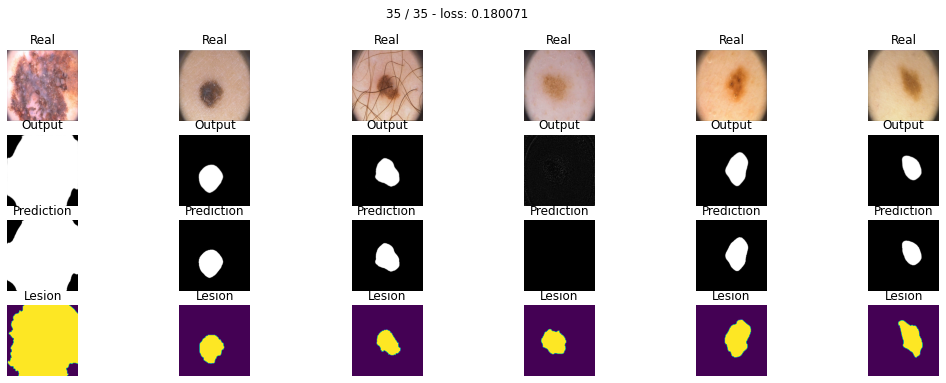

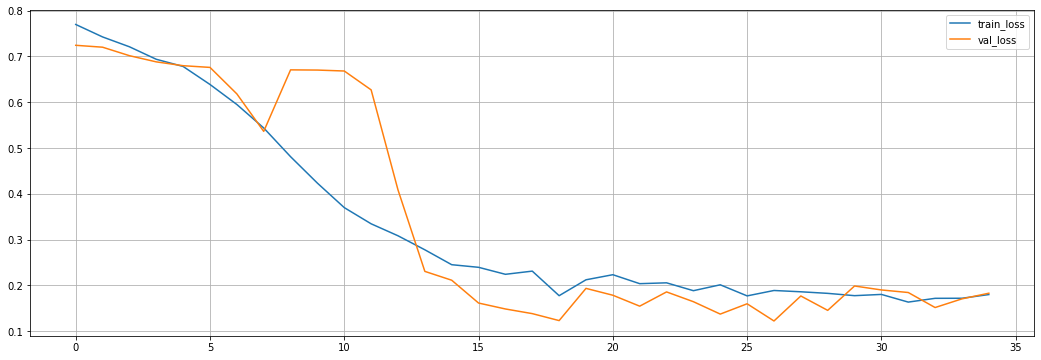

100%|██████████| 35/35 [06:55<00:00, 11.86s/it]


In [53]:
model_ssim = SegNet().to(device)

max_epochs = 35
optimaizer = optim.AdamW(model_ssim.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=15, gamma=0.5)
train(model_ssim, optimaizer, exp_lr_scheduler, SSIM_loss, max_epochs, data_tr, data_val)

In [54]:
score_model(model_ssim, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6319999098777771

In [55]:
score_model(model_ssim, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6040000319480896

In [56]:
del model_ssim

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

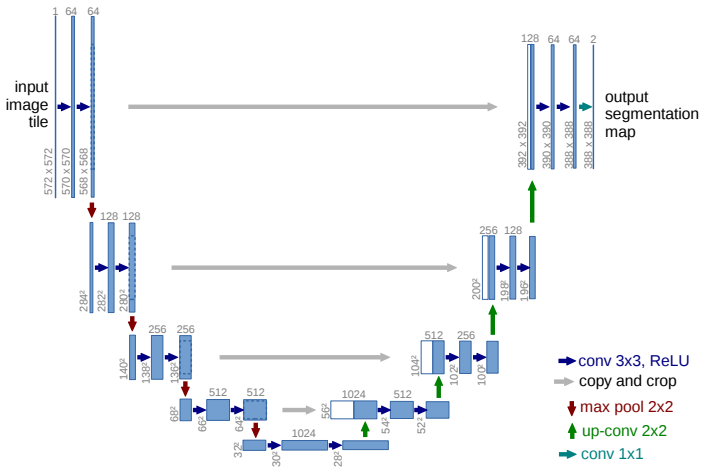

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [57]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2)# 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)# 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2)# 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )

        self.upsample1 =  nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, 
                      kernel_size=1, stride=1, 
                      padding=0),
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), self.enc_conv3(e2)), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), self.enc_conv2(e1)), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), self.enc_conv1(e0)), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), self.enc_conv0(x)), dim=1)) # no activation
        return d3

In [77]:
unet_model = UNet().to(device)

In [78]:
summary(unet_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

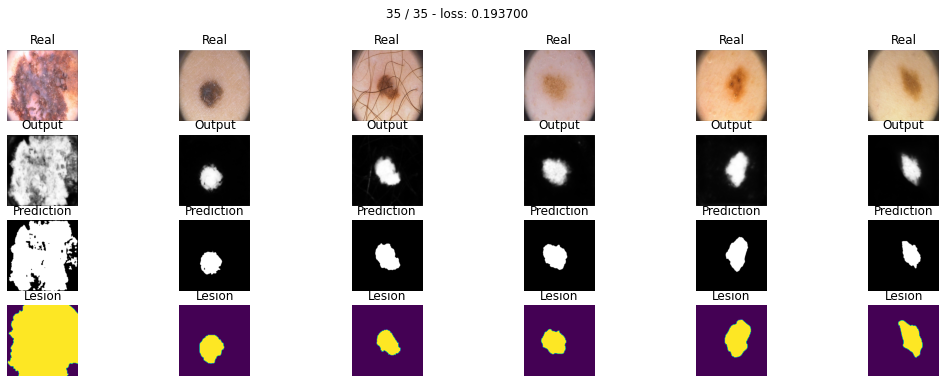

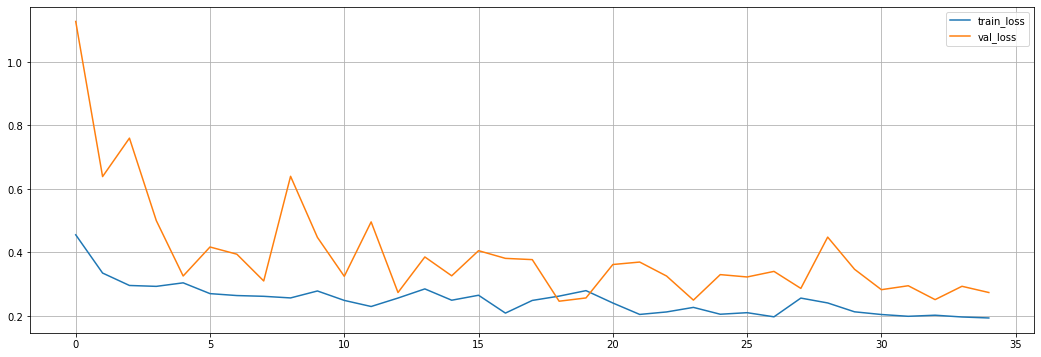

100%|██████████| 35/35 [07:28<00:00, 12.83s/it]


In [59]:
max_epochs = 35
optimaizer = optim.AdamW(unet_model.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=15, gamma=0.5)
train(unet_model, optimaizer, exp_lr_scheduler, bce_loss, max_epochs, data_tr, data_val)

In [60]:
score_model(unet_model, iou_pytorch, data_val)

0.6520000696182251

In [61]:
score_model(unet_model, iou_pytorch, data_ts)

0.7179999351501465

In [79]:
del unet_model

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [63]:
class UNet2(UNet):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels=64, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 =  nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, 
                               out_channels=256, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels=512, 
                               out_channels=512, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, 
                                            out_channels=512, 
                                            kernel_size=2, 
                                            stride=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )

        self.upsample1 =  nn.ConvTranspose2d(in_channels=256, 
                                            out_channels=256, 
                                            kernel_size=2, 
                                            stride=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(in_channels=128, 
                                            out_channels=128, 
                                            kernel_size=2, 
                                            stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, 
                                            out_channels=64, 
                                            kernel_size=2, 
                                            stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, 
                      kernel_size=1, stride=1, 
                      padding=0),
        )

In [80]:
unet2_model = UNet2().to(device)

In [81]:
summary(unet2_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]          36,928
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
           Conv2d-14          [-1, 128,

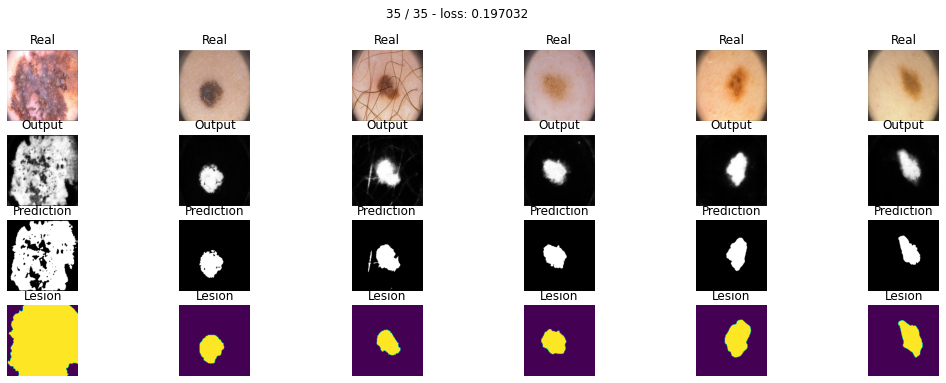

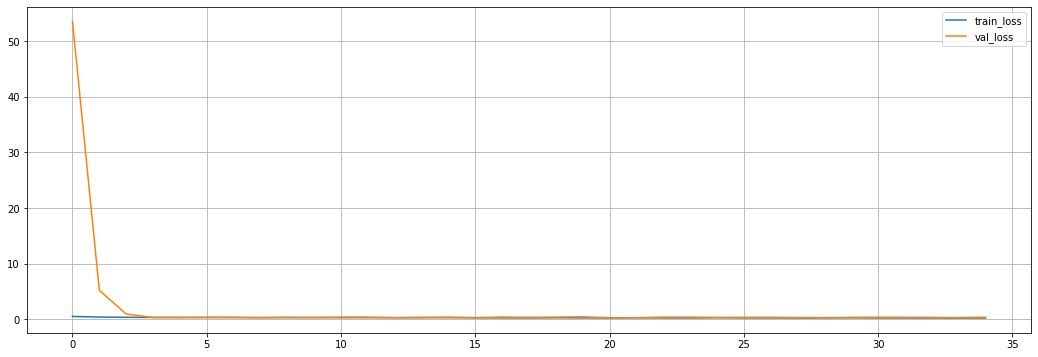

100%|██████████| 35/35 [08:29<00:00, 14.57s/it]


In [69]:
max_epochs = 35
optimaizer = optim.AdamW(unet2_model.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(unet2_model, optimaizer, exp_lr_scheduler, bce_loss, max_epochs, data_tr, data_val)

In [70]:
score_model(unet2_model, iou_pytorch, data_val)

0.6700000166893005

In [71]:
score_model(unet2_model, iou_pytorch, data_ts)

0.718000054359436

In [82]:
del unet2_model

Обучим лучшую модель (сильно углубляться в оптимизаторы, стратегию изменения lr не будем)

In [99]:
unet2_model_best = UNet2().to(device)

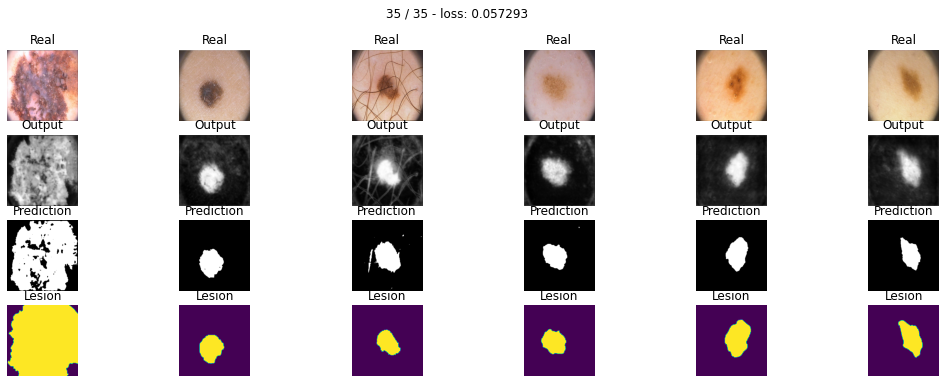

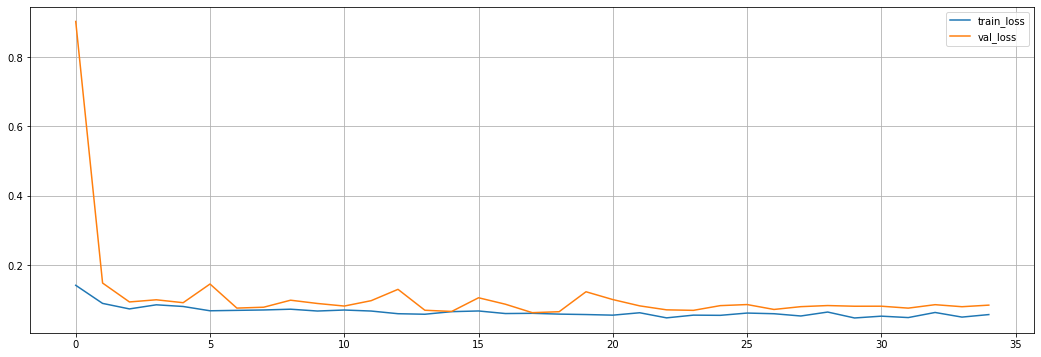

100%|██████████| 35/35 [08:26<00:00, 14.47s/it]


In [100]:
max_epochs = 35
optimaizer = optim.AdamW(unet2_model_best.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimaizer, step_size=7, gamma=0.5)
train(unet2_model_best, optimaizer, exp_lr_scheduler, focal_loss, max_epochs, data_tr, data_val)

In [101]:
score_model(unet2_model_best, iou_pytorch, data_val)

0.6679999828338623

In [102]:
score_model(unet2_model_best, iou_pytorch, data_ts)

0.7280000448226929

In [103]:
del unet2_model_best

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Отчет по проделанной работе

1.   В данной работе было предложено ознакомиться с различными архитектурами нейронных сетей, loss функциями, которые можно использовать в ходе обучения и оценить качество моделей с помощью метрики IoU.
2.   В ходе обучения моделей возникают случайности, поэтому в начале ноутбука были зафиксированы seed-ы чтобы постараться сделать воспроизводымий ноутбук. Но полной фиксации параметров **не удалось** достичь (например начальные веса в моделях все равно задаются разные при каждом новом обучении - это можно отследить по кривым обучения каждой модели). Вследствие неполной фиксации случайностей в работе результаты моделей могут варьироваться. Значения метрик, приведенные далее, были получены при запуске всех ячеек в одной среде выполнения.
3. Далее был написан Dataset для имеющихся картинок и масок для них. Это было сделано, чтобы осуществить применение аугментации к тренировочной выборке, что позволило увеличить обобщающую способность наших моделей. В ходе исследования было выяснено, что применение аугментаций позволяет улучшить качество моделей по метрике IoU в среднем на 0.04.
4. Был написан Dataloader для подгрузки данных в ходе обучения. Первоначально размер батча был выбран 25, но в ходе обучения из-за большого размера самих моделей и, в следсвтие переволнения памяти в Colab, был выбран **batch_size=10**, что позволило обучить все модели (НО после цикла обучения каждая модель удалялась из памяти).
5. Была реализована модель SegNet, за основу которой была взята архитектура vgg16_bn со всеми слоями из feature-extractor.
6. Был реализован цикл обучения моделей (в него дополнительным параметром был добавлен lr_scheduler), функция предсказания моделью сегментационных картин и определение метрики, характеризующей качество модели.
7. В таблицах ниже приведены результаты оценки метрики IoU для различных моделей и различных функций потерь (присания всех loss функций приведены по ссылкам).

| data/loss | bce_loss | dice_loss | focal_loss | log_cosh_loss | distance_loss | SSIM_loss |
|-----------|----------|-----------|------------|---------------|---------------|-----------|
| val       |  0.56        |    0.654       |     0.656       |    0.598           |     0.674          |     0.632      |
| test      |   0.624       |      0.684     |      0.684      |    0.686           |       0.66        |   0.604        |


| data/Net (bce_loss) | SegNet | UNet   | UNet2 | UNet2(focal_loss) |
|---------------------|--------|--------|-------|-------------------|
| val                 | 0.56   | 0.652  | 0.67  | 0.668             |
| test                | 0.624  | 0.7179 | 0.718 | 0.728             |

8. В первой таблице приведены результаты обучения SegNet при различных функциях ошибки. Очень схожие результаты дают dice_loss, focal_loss и log_cosh_loss (в ходе предыдуших циклов обучения лучший результат давал focal_loss). При этом log_cosh_loss является производной ошибкой от dice_loss. Худший результат показала SSIM_loss (в некоторых случаях данная ошибка давала результать 0.16, что может быть связано в определением гауссовских окон, используемыв для вычисления данной ошибки). Среди всех ошибок, используемых в сегнете меньшую резкость краев имеет SSIM_loss(видно из предсказаний маски на валидационной выборке), что, например, в медицинских задачах не может быть приемлемо, так как границы объектов должны быть четко отрисованы.
9. Лучшей среди 3 моделей, использующих bce_loss стала UNet2, при этом отрыв от UNet небольшой. Вообще лучшей моделью была выбрана UNet2 на основе focal_loss, показавшая результат 0.728 (при этом не проводилось глубокое изучение параметров оптимизаторов приводящих к лучшему результату обучения сети).
10. Для каждой модели в ходе обучения строились кривые обучения, а так же предсказания модели и реальные маски, для более наглядного представления процесса обучения алгоритма. Как видно, некоторые модели реагируют на контрастные объекты на картинках и помечают их как целевой класс (волоски на предсказанных масках тоже выделяются иногда как родинки). На графиках обучения видно снижения лосса на train и val выборке, что говорит о нормальном протекании процесса обучения. Кривые обучения не всегда являются репрезентативными для глаза, потому что в завимисти он начально инициализированных весов, лосс на первых эпохах может быть очень большой в сравнении с дальнейним процессом обучения. Для некоторых моделей наверное можно говорить о процессе переобучения, но это было допущено для возможности сравнения характеристик сетей (для каждой сетки было отведено 35 эпох обучения, начальный lr=1e-3, этот lr уменьшался в 0.5 раз каждые 10 эпох, оптимизатор AdamW). Только по крывым обучения нельзя сказать насколько та или иная модель лучше (как минимум размерности у этих величин разные), но можно отследить динамику обучения модели. Так же одинаковые параметры обучения моделей были взяты для возможности сравнения времени обучения каждого алгоритма, в таблице приведены сведения о времени обучения разных моделей.

| NN             | SegNet (bce_loss) | SegNet (dice_loss) | SegNet (focal_loss) | SegNet (log_cosh_loss) | SegNet (distance_loss) | SegNet (SSIM_loss) | UNet (bce_loss) | UNet2 (bce_loss) | UNet2 (focal_loss) |
|----------------|-------------------|--------------------|---------------------|------------------------|------------------------|--------------------|-----------------|------------------|--------------------|
| time/epoch(s)  | 9.97              | 10.03              | 9.99                | 9.97                   | 9.95                   | 11.86              | 12.83           | 14.57            | 14.47              |
| full_time(min) | 5.48              | 5.51               | 5.49                | 5.49                   | 5.48                   | 6.55               | 7.28            | 8.29             | 8.26               |

11. Видно что быстрее обучается Segnet, но так же время обучения зависит от loss функции (SSIM_loss сложна в вычислении, поэтому время обучения этой модели примерно на 20% дольше, чем у остальных). Как видно из таблицы UNet обучается быстрее UNet2, это может выть вызвано заменой maxpooling на свертку, что дольше по вычислению. Тут мы можем прийти к выводу, что **за качество модели, нужно платить временем ее обучения и работы**.





12. С помощью torchsummary посмотрели на размер моделей:

| NN                              | SegNet      | UNet       | UNet2      |
|---------------------------------|-------------|------------|------------|
| Total params                    | 29,722,369  | 17,514,241 | 22,042,241 |
| Forward/backward pass size (MB) | 11148578.12 | 1115.00    | 1115.00    |
| Params size (MB)                | 113.38      | 66.81      | 84.08      |
| Estimated Total Size (MB)       | 11148692.26 | 1182.56    | 1199.83    |

13. Как видно SegNet более тяжелая модель с бОльшим количеством обучаемых параметров, что связано с бОльшей глубиной энкодера, в котором представлены сверточные слои. Так же явное различие в количестве параметров заметно в UNet и UNet2, где мы заменили maxpool на сверточные слои, что увеличило количество параметров. Также видно, что в ходе обучения проброс данных в прямом и обратном направлении SegNet на порядки больше, чем у Unet архитектуры. Это может быть связано с отсутствием skip-connections, по которым данные проходят без преобразований. 
